## HR prediction project

In this project we will try to predict is someone is looking for a job change based on some features. This is a classification problem and a dataset was taken from [kaggle](https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists). There is also an app [Streamlit]() for this project were one can perform some analysis and inference on the test set.

In [112]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve, roc_auc_score
from imblearn.combine import SMOTEENN
from lightgbm import LGBMClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import uniform
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from scipy.stats import skew
from scipy.special import boxcox1p
from pycaret.classification import *

%matplotlib inline

Lets first load the data and look at the general info.

In [113]:
df = pd.read_csv('aug_train.csv')

In [114]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [116]:
df.nunique()

enrollee_id               19158
city                        123
city_development_index       93
gender                        3
relevent_experience           2
enrolled_university           3
education_level               5
major_discipline              6
experience                   22
company_size                  8
company_type                  6
last_new_job                  6
training_hours              241
target                        2
dtype: int64

0.0    75.065247
1.0    24.934753
Name: target, dtype: float64

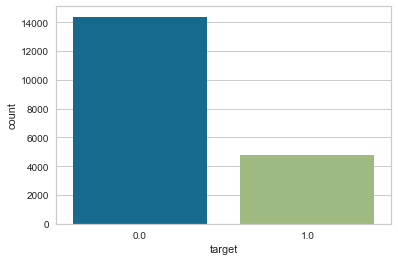

In [117]:
sns.countplot(data=df, x=df['target'])
df['target'].value_counts() * 100 / len(df)

It looks like the dataset is imbalanced. Now lets see how many missing values there are and if we have any duplicated entries.

In [118]:
df.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [119]:
df.duplicated(subset=df.columns[1:]).sum()

49

In [120]:
df.drop_duplicates(subset=df.columns[1:], inplace=True)

In [121]:
df.duplicated().sum()

0

There are a lot of missing values so we have to find the best way to impute them. Because we only have missing values for the categorical features a reasonable way to fill them is to create a new category *Not specified* for each of them. This is much better than the imputation with a most frequent value cause there can be a lot of categories for a single feature which are close to each other in the number of occurences. Imputation is done in the *custom_transformer* so that it can be later reuse for transformation on the test data.

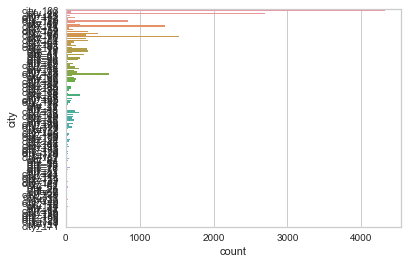

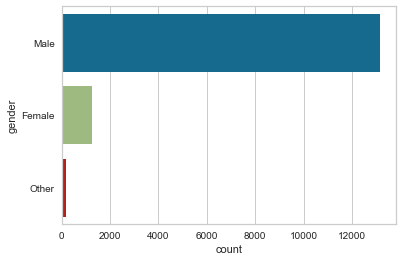

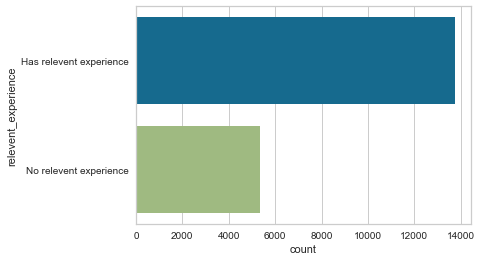

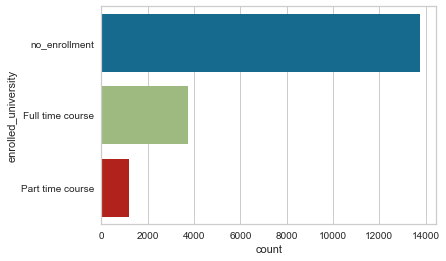

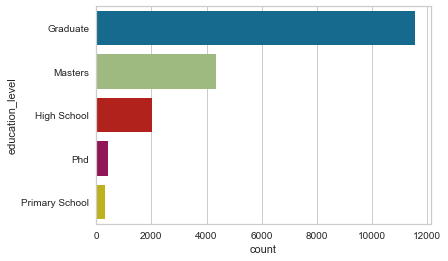

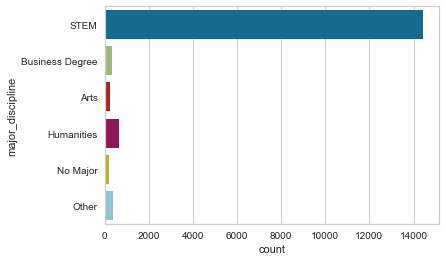

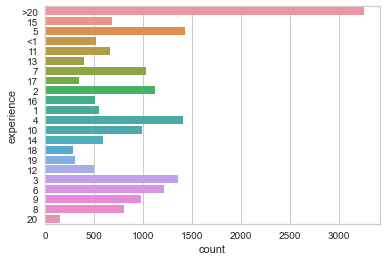

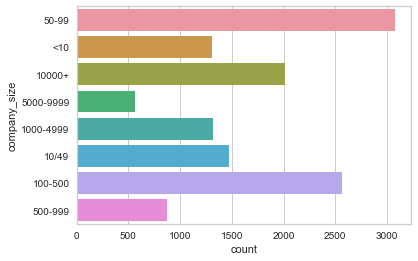

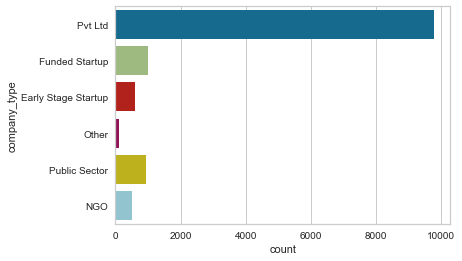

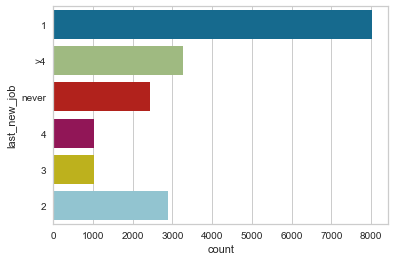

In [122]:
for col in df.select_dtypes('object'):
    sns.countplot(data=df, y=df[col])
    plt.show()

Next we have to look at the distributions for the numerical features.

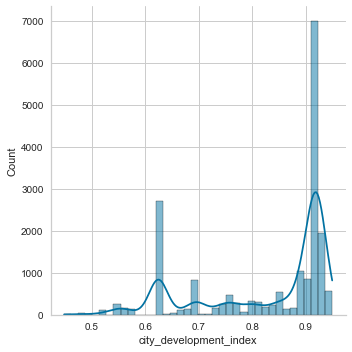

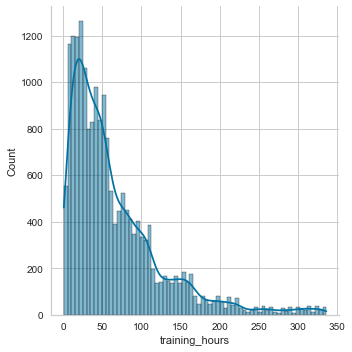

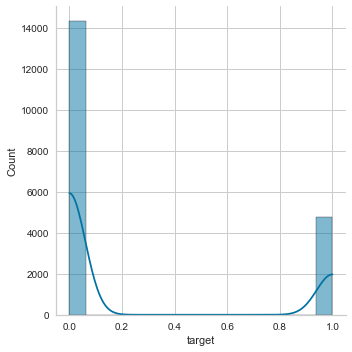

In [123]:
for col in df.describe().columns[1:]:
    sns.displot(df[col], kde=True)

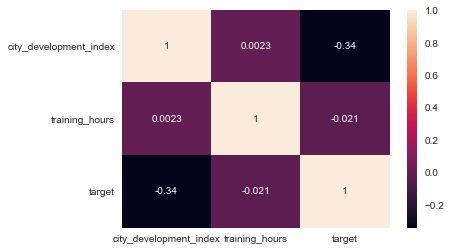

In [124]:
sns.heatmap(df[df.describe().columns[1:]].corr(), annot=True)

From the above distributions we can see that the *training_hours* feature is highly skewed and this will be a problem for some models like Logistic Regression. To solve this we can calculate the skewness of each numerical feature and based on some specified threshold apply the *boxcox* transformation which is similar to the *log* function. This way we can transform the skewed distribution so that it is more gaussian. This is done in the *skewness_remover* transformer.

In [125]:
class custom_transformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X):
        X_new = X.copy()
        self.cols = X_new.isna().sum()[X_new.isna().sum() != 0].index
        
        return self
        
    def transform(self, X):
        X_new = X.copy()
        X_new.drop('enrollee_id', axis=1, inplace=True)
        for col in self.cols:
            X_new.loc[X_new[col].isna(), col] = 'Not specified'
        
        return X_new

In [126]:
class skewness_remover(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X):
        X_new = X.copy()
        self.skewness = X_new[X_new.describe().columns].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
        self.skewness = self.skewness[self.skewness > 0.75]
        
        return self
        
    def transform(self, X):
        X_new = X.copy()
        for col in self.skewness.index:
            X_new[col] = boxcox1p(X_new[col], 0.0)
        
        return X_new

In [127]:
prep_pipeline_full = Pipeline([
    ('skewness', skewness_remover()),
    ('custom_transformer', custom_transformer())
])

For training we will use here a *PyCaret* library which is very good for fast prototyping and in general reduces the amonut of code which one have to write with sklearn.

In [128]:
to_transform = df.drop('target', axis=1)
df_caret = prep_pipeline_full.fit_transform(to_transform)
df_caret['target'] = df['target'].copy()

In [129]:
pickle.dump(prep_pipeline_full, open('prep_pipe.pkl', 'wb'))

After data preprocessing with custom transformers we have to specify the *setup* function which will do additional transformations like normalization of the numerical features and data splitting. We also include the removal features which are highly correlated with each other. Even tough we have only 12 featuers in the raw data, after applying one-hot encoding their number grow to almost 200. This is mainly due to the *city* feature which has 1234 categories. I was trying to remove it or create a new feature which only includes information about the most important categories but at the end score was a little bit lower than with all categories. Some of these categories are only removed through the *remove_multicollinearity* option. Imbalance of the data can be solved with the *SMOTE* method which can be used through the *fix_imbalance* parameter. It is an oversampling technique of minority class so that the resulting dataset is balanced. One has to keep in mind that it is not applied to the test data and only to the train set.

In [137]:
clf = setup(data=df_caret, target='target',
            train_size=0.85, 
            normalize=True,
            fold=5,
            data_split_stratify=True,
            fix_imbalance=True,
            remove_multicollinearity=True,
            session_id=4000)

,Description,Value
0,session_id,4000
1,Target,target
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(19109, 13)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,10
8,Ordinal Features,False
9,High Cardinality Features,False


Before training we will first look at the feature importances which are calculated using SHAP values. It can be seen below that the *city_development_index* is the most important feature. Higher index decreases the probability of changing the job and lower increases. Also introduced category for missing values seems to be important. Out of the 123 cities in 2 of them there is a high probability that people will change a job. Based on this analysis one can perform some feature engineering and add some new features. I have tried various combinations but nothing improved the score so I kept the original features only. It is possible that some further exploratory data analysis could improve the model performance. It is not done here but in the Streamlit app one can perform such analysis for all feature combinations.

In [19]:
cat = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7959,0.7990,0.5914,0.5906,0.5910,0.4550,0.4550
1,0.8046,0.8121,0.6025,0.6092,0.6058,0.4759,0.4759
2,0.7879,0.7908,0.5877,0.5728,0.5801,0.4382,0.4383
3,0.7934,0.7919,0.6037,0.5828,0.5931,0.4547,0.4548
4,0.7990,0.7910,0.5975,0.5968,0.5972,0.4632,0.4632
Mean,0.7961,0.7970,0.5965,0.5905,0.5934,0.4574,0.4575
SD,0.0056,0.0082,0.0062,0.0124,0.0084,0.0123,0.0123


In [54]:
save_model(cat, 'catboost')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='target',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strat...
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'),
                 ('fix_multi',
                  Fix_multicollinearity(correlation_with_target_preference=None,
                                        correlation_wit

In [55]:
cat = load_model('catboost')

Transformation Pipeline and Model Successfully Loaded


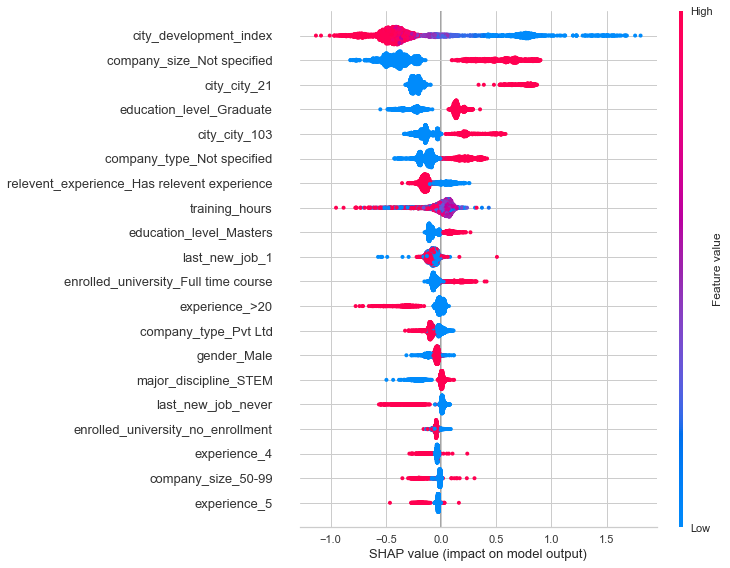

In [59]:
interpret_model(cat.get_params()['trained_model'])

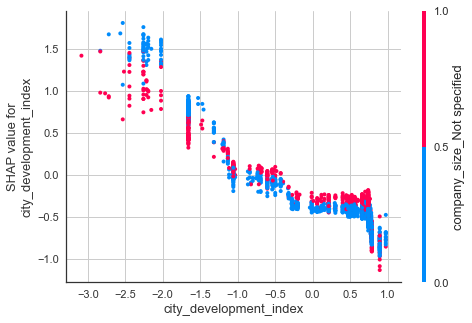

In [60]:
interpret_model(cat.get_params()['trained_model'], plot='correlation', feature='city_development_index')

Now we can look at the performance of the base models. From these models I chose 4 for fine-tuning. Catboost was skipped due to the very long training time. The metrics used for evaluation was the *AUC* score. So that we don't only look at the recall of the target class but also to correctly classify people who are not going to change the job.

In [51]:
compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7967,0.7984,0.6252,0.5869,0.6054,0.4687,0.4691,1.4340
catboost,CatBoost Classifier,0.7961,0.7970,0.5965,0.5905,0.5934,0.4574,0.4575,10.7340
gbc,Gradient Boosting Classifier,0.7919,0.7953,0.6958,0.5677,0.6252,0.4832,0.4881,3.3040
lr,Logistic Regression,0.7718,0.7931,0.7314,0.5309,0.6152,0.4588,0.4707,3.3420
lda,Linear Discriminant Analysis,0.7731,0.7919,0.7254,0.5330,0.6145,0.4590,0.4700,1.2760
rf,Random Forest Classifier,0.7853,0.7882,0.5217,0.5769,0.5479,0.4076,0.4085,2.1720
ada,Ada Boost Classifier,0.7804,0.7835,0.6647,0.5494,0.6014,0.4517,0.4558,1.4220
et,Extra Trees Classifier,0.7767,0.7664,0.4820,0.5607,0.5183,0.3741,0.3759,2.6460
knn,K Neighbors Classifier,0.6443,0.7254,0.7600,0.3905,0.5158,0.2780,0.3168,8.8660
dt,Decision Tree Classifier,0.7231,0.6401,0.4731,0.4478,0.4599,0.2739,0.2742,0.9920


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=4000, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [39]:
rf_tuned = tune_model(create_model('rf'), 
                       n_iter=100,
                       optimize='AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7815,0.7997,0.7346,0.5459,0.6263,0.4766,0.4871
1,0.8042,0.8177,0.7506,0.5835,0.6566,0.5227,0.5308
2,0.7685,0.7788,0.6975,0.5271,0.6004,0.4419,0.4505
3,0.7777,0.7913,0.7136,0.5412,0.6155,0.4633,0.4721
4,0.7909,0.7998,0.7358,0.5617,0.6371,0.4940,0.5028
Mean,0.7846,0.7975,0.7264,0.5519,0.6272,0.4797,0.4887
SD,0.0122,0.0127,0.0187,0.0193,0.0191,0.0274,0.0273


In [145]:
rf_tuned

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       n_estimators=290, n_jobs=-1, oob_score=False,
                       random_state=4000, verbose=0, warm_start=False)

In [34]:
gbc_tuned = tune_model(create_model('gbc'), n_iter=150, optimize='AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7852,0.8013,0.7235,0.5528,0.6267,0.4797,0.4882
1,0.8018,0.8209,0.7432,0.5800,0.6515,0.5159,0.5237
2,0.7762,0.7855,0.6975,0.5396,0.6085,0.4553,0.4627
3,0.7783,0.7940,0.7111,0.5424,0.6154,0.4636,0.4720
4,0.7956,0.8015,0.7358,0.5698,0.6422,0.5024,0.5104
Mean,0.7874,0.8006,0.7222,0.5569,0.6289,0.4834,0.4914
SD,0.0099,0.0117,0.0165,0.0156,0.0161,0.0229,0.0229


In [146]:
gbc_tuned

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=5,
                           max_features=1.0, max_leaf_nodes=None,
                           min_impurity_decrease=0.0001,
                           min_impurity_split=None, min_samples_leaf=1,
                           min_samples_split=5, min_weight_fraction_leaf=0.0,
                           n_estimators=200, n_iter_no_change=None,
                           presort='deprecated', random_state=4000,
                           subsample=0.4, tol=0.0001, validation_fraction=0.1,
                           verbose=0, warm_start=False)

In [31]:
param_grid ={'num_leaves': list(range(1, 100)), 
             'learning_rate': np.power(10, np.arange(-5., 0.)),
             'n_estimators': list(range(100, 1500)),
             'min_child_weight': np.power(10, np.arange(-15., -1)),
             'reg_alpha': np.power(10, np.arange(-5., 1.)),
             'reg_lambda': np.power(10, np.arange(-5., 1.)),
             'feature_fraction': uniform(loc=0., scale=1.),
             'bagging_fraction': uniform(loc=0., scale=1.),
             'bagging_freq': np.arange(1, 10)
            }

lgb_tuned = tune_model(create_model('lightgbm'), 
                       n_iter=150,
                       custom_grid=param_grid,
                       optimize='AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7889,0.8006,0.7210,0.5594,0.6300,0.4855,0.4932
1,0.8107,0.8230,0.7358,0.5978,0.6597,0.5305,0.5360
2,0.7808,0.7886,0.6852,0.5484,0.6092,0.4595,0.4650
3,0.7891,0.7961,0.7012,0.5618,0.6238,0.4798,0.4855
4,0.8011,0.8000,0.7198,0.5818,0.6435,0.5077,0.5132
Mean,0.7941,0.8017,0.7126,0.5699,0.6332,0.4926,0.4986
SD,0.0105,0.0115,0.0176,0.0177,0.0172,0.0244,0.0243


In [148]:
lgb_tuned

LGBMClassifier(bagging_fraction=0.9090111611677784, bagging_freq=4,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.6225207643958737, importance_type='split',
               learning_rate=0.001, max_depth=-1, min_child_samples=20,
               min_child_weight=1e-09, min_split_gain=0.0, n_estimators=383,
               n_jobs=-1, num_leaves=42, objective=None, random_state=4000,
               reg_alpha=1.0, reg_lambda=0.1, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [28]:
param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C':  np.power(10, np.arange(-5., 2.))
}

lr_tuned = tune_model(create_model('lr'), 
                      custom_grid=param_grid, 
                      search_algorithm='grid',
                      optimize='AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7682,0.7979,0.7531,0.5245,0.6183,0.4595,0.4750
1,0.7873,0.8152,0.7827,0.5518,0.6473,0.5015,0.5172
2,0.7595,0.7812,0.7259,0.5126,0.6009,0.4361,0.4496
3,0.7632,0.7912,0.7296,0.5180,0.6058,0.4435,0.4568
4,0.7783,0.7922,0.7506,0.5400,0.6281,0.4761,0.4892
Mean,0.7713,0.7955,0.7484,0.5294,0.6201,0.4633,0.4776
SD,0.0102,0.0112,0.0203,0.0145,0.0166,0.0235,0.0242


In [147]:
lr_tuned

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=4000, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [153]:
blender = blend_models([lr_tuned, lgb_tuned, rf_tuned, gbc_tuned], method='soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7836,0.8014,0.7358,0.5493,0.6290,0.4808,0.4910
1,0.8055,0.8200,0.7568,0.5849,0.6598,0.5268,0.5353
2,0.7740,0.7845,0.7086,0.5354,0.6100,0.4552,0.4641
3,0.7808,0.7957,0.7222,0.5457,0.6217,0.4715,0.4807
4,0.7940,0.7998,0.7420,0.5664,0.6424,0.5014,0.5104
Mean,0.7876,0.8003,0.7331,0.5564,0.6326,0.4871,0.4963
SD,0.0110,0.0115,0.0165,0.0174,0.0172,0.0248,0.0246


In [43]:
stacking = stack_models(estimator_list=[lgb_tuned, rf_tuned, gbc_tuned], meta_model=lr_tuned)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7864,0.8043,0.7383,0.5537,0.6328,0.4865,0.4965
1,0.8067,0.8213,0.7568,0.5872,0.6613,0.5290,0.5374
2,0.7771,0.7876,0.7099,0.5404,0.6137,0.4610,0.4695
3,0.7826,0.7986,0.7222,0.5488,0.6237,0.4748,0.4837
4,0.7946,0.8007,0.7395,0.5678,0.6424,0.5018,0.5104
Mean,0.7895,0.8025,0.7333,0.5596,0.6348,0.4906,0.4995
SD,0.0103,0.0109,0.0160,0.0164,0.0163,0.0234,0.0233


In terms of performance the best score of a single model was achieved with the LGBMClassifier but the differences were in general very small. Most of these models can probably perform better since the number of iterations in hyperparameters searching was limited by the speed of computations which vas very slow. At the end I have tried blending fine-tuned models and also stacking them. Stacking performed slightly better so this is the final model.

In [111]:
save_model(stacking, 'stacking_clf')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='target',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strat...
                                                                    importance_type='split',
                                                                    learning_rate=0.001,
                                                                    max_depth=-1,
          

In [131]:
stacking_model = load_model('stacking_clf')

Transformation Pipeline and Model Successfully Loaded


Now we can predict on the test set and look at the performance with comparison to the cross-validation data.

In [141]:
predict_model(stacking_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.7953,0.8020,0.7119,0.5719,0.6343,0.4944,0.5002


,city_development_index,training_hours,city_city_10,city_city_100,city_city_101,city_city_102,city_city_103,city_city_104,city_city_105,city_city_106,...,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_Not specified,last_new_job_never,target,Label,Score
0,0.790420,-1.024323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.5773
1,-1.658060,0.408848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5954
2,0.895818,1.157093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6236
3,0.741775,0.837249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.6233
4,-2.833655,0.847868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.5723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862,-2.022900,0.868791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5582
2863,-0.677046,0.136434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.5176
2864,0.790420,0.571718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.6158
2865,0.741775,-0.202626,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.5783


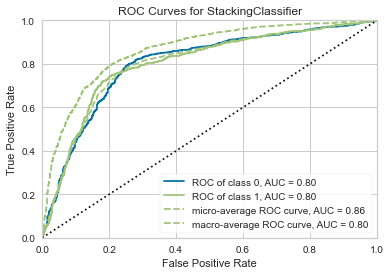

In [139]:
plot_model(stacking_model.get_params()['trained_model'], 'auc')

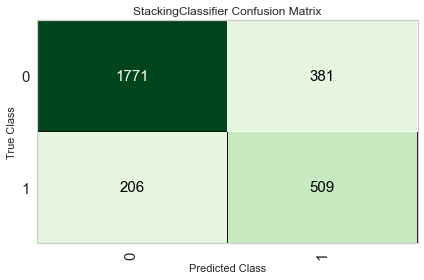

In [140]:
plot_model(stacking_model.get_params()['trained_model'], 'confusion_matrix')

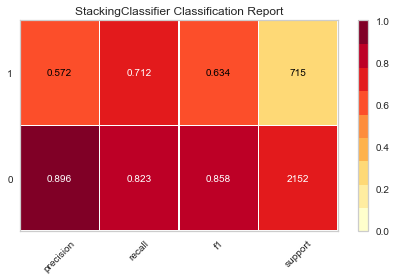

In [142]:
plot_model(stacking_model.get_params()['trained_model'], 'class_report')

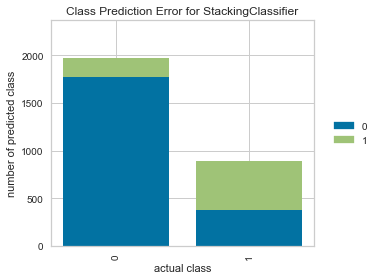

In [143]:
plot_model(stacking_model.get_params()['trained_model'], 'error')

It looks like it is not much worse. Finally we can also run the inference on the test data which does not have a target and was available on kaggle. We will use it in the Streamlit app. 

In [33]:
test_data = pd.read_csv('aug_test.csv')
test_data_prep = prep_pipeline_full.transform(test_data)
predict_model(stacking_model, data=test_data_prep)

Transformation Pipeline and Model Successfully Loaded


,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,Label,Score
0,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,Not specified,1,3.091042,0.0,0.5926
1,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,Not specified,Pvt Ltd,1,4.595120,0.0,0.5095
2,city_21,0.624,Male,No relevent experience,no_enrollment,High School,Not specified,<1,Not specified,Pvt Ltd,never,2.772589,1.0,0.5626
3,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,3.688879,0.0,0.6236
4,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,4.290459,0.0,0.6220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,city_103,0.920,Male,No relevent experience,no_enrollment,Graduate,Humanities,16,Not specified,Public Sector,4,2.772589,1.0,0.5134
2125,city_136,0.897,Male,Has relevent experience,no_enrollment,Masters,STEM,18,Not specified,Not specified,2,3.433987,0.0,0.5840
2126,city_100,0.887,Male,No relevent experience,no_enrollment,Primary School,Not specified,3,Not specified,Pvt Ltd,never,2.944439,0.0,0.6237
2127,city_102,0.804,Male,Has relevent experience,Full time course,High School,Not specified,7,100-500,Public Sector,1,4.442651,0.0,0.6222
